In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

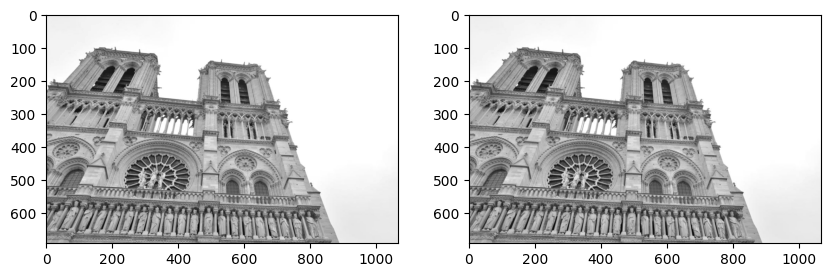

In [2]:
img1 = '../data/train/notre_dame_front_facade/images/01516300_11234314903.jpg'
img2 = '../data/train/notre_dame_front_facade/images/01569849_8047248507.jpg'
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
img1 = cv.imread(img1, cv.IMREAD_GRAYSCALE)
img2 = cv.imread(img2, cv.IMREAD_GRAYSCALE)
ax[0].imshow(img1, cmap='gray')
ax[1].imshow(img1, cmap='gray')

In [3]:
from numpy import ndarray
from cv2 import GaussianBlur, resize

class SIFT(object):

    def __init__(self, initial_sigma: float = 1.6, n_scales_per_octave: int = 3, n_octaves: int = 4) -> None:
        self.initial_sigma = initial_sigma
        self.n_scales_per_octave = n_scales_per_octave
        self.n_octaves = n_octaves
    
    def compute_gaussian_scales(self) -> ndarray:
        """Create a list of gaussian kernels for each octave and scale"""
        k = 2 ** (1 / self.n_scales_per_octave)
        # We must produce s + 3 images in the stack of blurred images for each octave
        self.n_intervals = self.n_scales_per_octave + 3

        self.gaussian_scales = np.zeros(self.n_intervals)
        for step in range(self.n_intervals):
            self.gaussian_scales[step] = self.initial_sigma * k**step 

        return self.gaussian_scales


    def gaussian_images(self, image: np.ndarray) -> ndarray:
        """Create a stack of blurred images for each octave and scale.
        
        Args:
            image (np.ndarray): Input image.
        """

        if not hasattr(self, 'gaussian_scales'):
            self.compute_gaussian_scales()
        
        gaussianed_images = {} 

        for octave in range(self.n_octaves):
            gaussianed_images[octave] = {}
            for scale in range(self.n_intervals):
                new_image = GaussianBlur(image,(0, 0), sigmaX=self.gaussian_scales[scale], sigmaY=self.gaussian_scales[scale])
                gaussianed_images[octave][scale] = new_image 
            image = resize(image, (image.shape[1] // 2, image.shape[0] // 2))

        return gaussianed_images
    
    def compute_dog_images(self, gaussianed_images: ndarray) -> ndarray:
        """Compute the difference of gaussian images for each octave and scale.
        
        Args:
            gaussian_images (ndarray): Stack of blurred images for each octave and scale.
        """
        dog_images = {}
        for octave in range(self.n_octaves):
            dog_images[octave] = {}
            for scale in range(self.n_intervals - 1):
                dog_images[octave][scale] = gaussianed_images[octave][scale + 1] - gaussianed_images[octave][scale]
        return dog_images
    
    def is_keypoint(self, dog_images: ndarray, octave: int, scale: int, i: int, j: int) -> bool:
        for x in [-1, 0, 1]:
            for y in [-1, 0, 1]:
                for z in [-1, 0, 1]:
                    if dog_images[octave][scale][i][j] < dog_images[octave][scale + z][i + x][j + y]:
                        return False
        return True
    
    def find_keypoints(self, dog_images: ndarray) -> ndarray:
        """Find the keypoints in the difference of gaussian images.
        
        Args:
            dog_images (ndarray): Stack of difference of gaussian images for each octave and scale.
        """
        keypoints = []
        for octave in range(self.n_octaves):
            for scale in range(1, self.n_scales_per_octave):
                for i in range(1, dog_images[octave][scale].shape[0] - 1):
                    for j in range(1, dog_images[octave][scale].shape[1] - 1):
                        if self.is_keypoint(dog_images, octave, scale, i, j):
                            keypoints.append((octave, scale, i, j))
        return keypoints

In [4]:
sift = SIFT()
gaussianed_images = sift.gaussian_images(img1)
dog_images = sift.compute_dog_images(gaussianed_images)
key_points = sift.find_keypoints(dog_images)

In [5]:
points = np.array(key_points)[:, 2:]

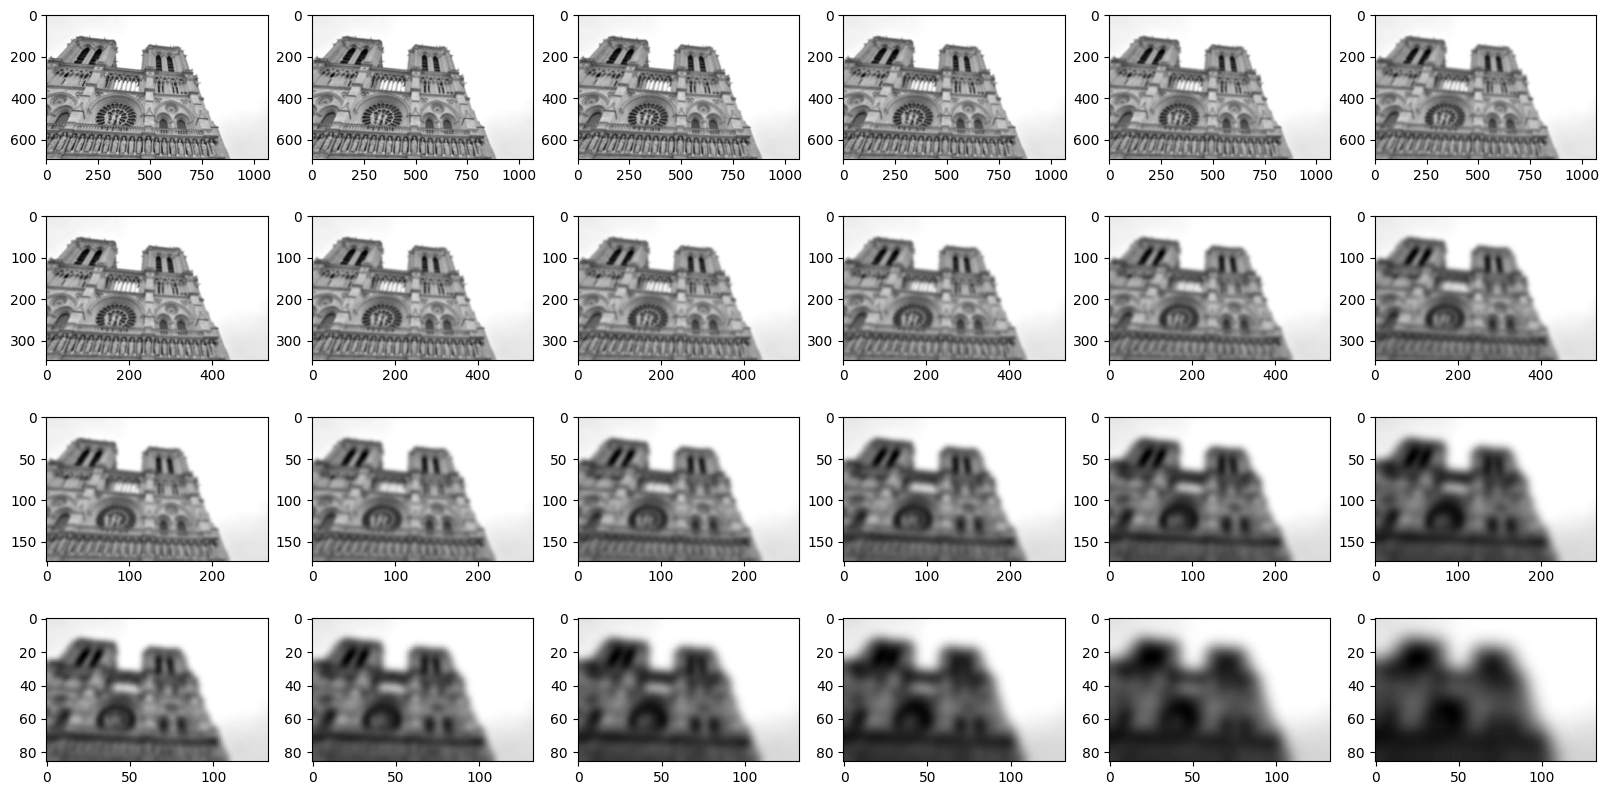

In [6]:
fig, ax = plt.subplots(sift.n_octaves, sift.n_intervals, figsize=(20, 10))
for octave in range(sift.n_octaves):
    for scale in range(sift.n_intervals):
        ax[octave][scale].imshow(gaussianed_images[octave][scale], cmap='gray')

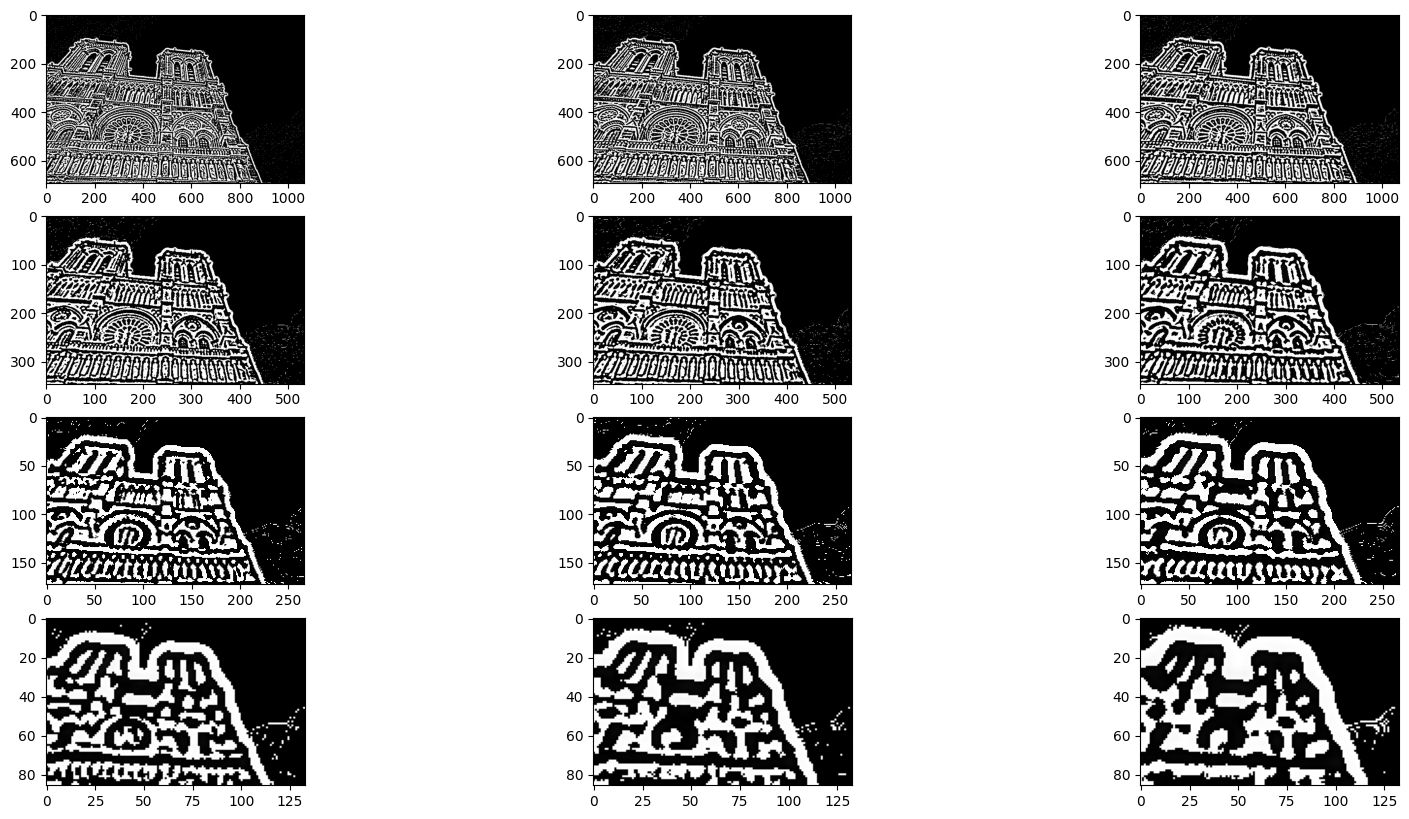

In [7]:
fig, ax = plt.subplots(sift.n_octaves, sift.n_scales_per_octave, figsize=(20, 10))
for octave in range(sift.n_octaves):
    for scale in range(sift.n_scales_per_octave):
        ax[octave][scale].imshow(dog_images[octave][scale], cmap='gray')

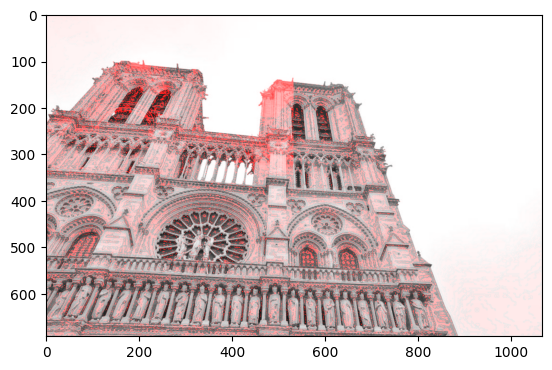

In [8]:
points = np.array(key_points)[:, 2:]
colored_img = cv.cvtColor(img1, cv.COLOR_GRAY2RGB)
for i, j in points:
    colored_img[i][j][0] = 255
plt.imshow(colored_img)